### Setting up the environment

**Create:**

environment.yml

```
name: object-detection-oidv4
channels:
  - conda-forge
  - anaconda
dependencies:
  - python=3.6.9
  - numpy=1.16.5
  - tensorflow=1.13.1
  - matplotlib=3.1.1
  - pillow=6.1.0
  - pandas=0.25.1
  - jupyter=1.0.0
  - ipython=7.8.0
```

**Execute:**

`$ conda env create -f environment.yml`

`$ conda activate object-detection-oidv4`

In [1]:
!pip install tensorflow==1.13.1


     |████████████████████████████████| 92.6MB 42kB/s 
     |████████████████████████████████| 3.2MB 43.6MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 368kB 41.0MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.13.1 which is incompatible.
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


### Validating Tensorflow version

In [2]:

import tensorflow as tf
print(tf.__version__)
from distutils.version import StrictVersion

if StrictVersion(tf.__version__) != StrictVersion('1.13.1'):
    raise ImportError('Please use tensorflow 1.13.1 for this notebook.')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


### Configuring inline plotting

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

### Importing some common libraries

In [4]:
import os

import urllib
import tarfile

import numpy as np

### Getting the model file

In [5]:
MODEL_DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12'
MODEL_FILE = MODEL_NAME + '.tar.gz'

if os.path.exists(MODEL_FILE) is False:
    opener = urllib.request.URLopener()
    opener.retrieve(MODEL_DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

### Getting the box description file

In [6]:
BOX_DESCRIPTIONS_FILE = 'class-descriptions-boxable.csv'
OID_DOWNLOAD_BASE = 'https://storage.googleapis.com/openimages/2018_04/'

if os.path.exists(BOX_DESCRIPTIONS_FILE) is False:
    opener = urllib.request.URLopener()
    opener.retrieve(OID_DOWNLOAD_BASE + BOX_DESCRIPTIONS_FILE, BOX_DESCRIPTIONS_FILE)

### Getting some test images

In [7]:
TEST_IMAGES = {
    'cat.jpg': 'https://c2.staticflickr.com/7/6118/6370710013_cb6b0270d3_o.jpg',
    'dog.jpg': 'https://c3.staticflickr.com/1/92/246323809_f8a8ab71fe_o.jpg',
    'pets.jpg': 'https://live.staticflickr.com/3273/2982384735_eeecaf03f2_b.jpg'
}

for filename, url in TEST_IMAGES.items():
    if os.path.exists(filename) is False:
        opener = urllib.request.URLopener()
        opener.retrieve(url, filename)

### Extracting the model files

In [8]:
FROZEN_GRAPH_FILE = 'frozen_inference_graph.pb'
PATH_TO_FROZEN_GRAPH = os.path.join(MODEL_NAME, FROZEN_GRAPH_FILE)

if os.path.exists(MODEL_NAME) is False:
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        filename = os.path.basename(file.name)
        if FROZEN_GRAPH_FILE in filename:
            tar_file.extract(file, os.getcwd())

### Loading the box descriptions into a dictionary

In [9]:
import pandas as pd

ID_KEY = 'id'
CLASS_KEY = 'class'
NAME_KEY = 'name'

df = pd.read_csv(BOX_DESCRIPTIONS_FILE, names=[ID_KEY, CLASS_KEY])
category_index = {}
for idx, row in df.iterrows():
    category_index[idx+1] = {ID_KEY: row[ID_KEY], NAME_KEY: row[CLASS_KEY]}

### Checking some labels

In [10]:
print(category_index[1])   # {'id': '/m/011k07', 'name': 'Tortoise'}
print(category_index[100]) # {'id': '/m/01nkt', 'name': 'Cheese'}
print(category_index[300]) # {'id': '/m/04_sv', 'name': 'Motorcycle'}
print(category_index[601]) # {'id': '/m/0zvk5', 'name': 'Helmet'}

{'id': '/m/011k07', 'name': 'Tortoise'}
{'id': '/m/01nkt', 'name': 'Cheese'}
{'id': '/m/04_sv', 'name': 'Motorcycle'}
{'id': '/m/0zvk5', 'name': 'Helmet'}


### Loading the frozen model from file

In [11]:
graph = tf.Graph()
with graph.as_default():
    graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(graph_def, name='')

### Checking original test images

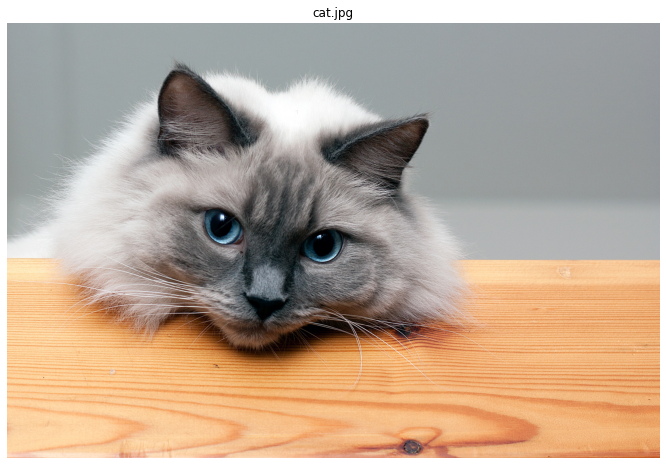

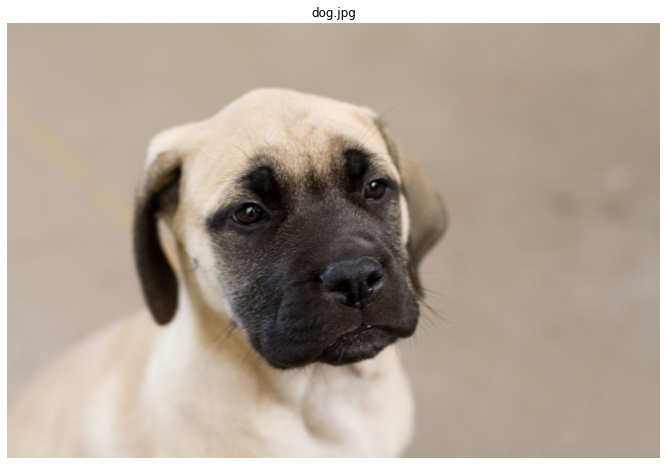

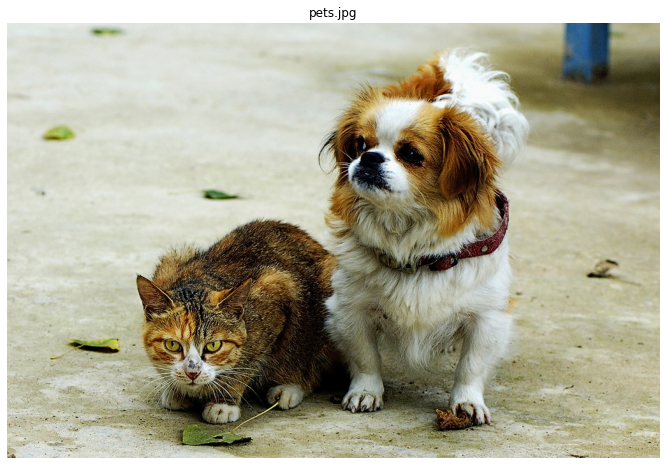

In [12]:
from PIL import Image

IMAGE_SIZE = (12, 8)


def show_image(filename, image):
    """
    Shows the given image with its filename as title.
    :param filename: image filename
    :param image: image to show
    """
    plt.figure(figsize=IMAGE_SIZE)
    plt.title(filename)
    plt.axis('off')
    plt.imshow(image)


for filename, _ in TEST_IMAGES.items():
    original_image = Image.open(filename)
    show_image(filename, original_image)


### Defining some helper code

In [13]:
# Font to draw text on image
FONT_NAME = 'Ubuntu-R.ttf'

# Bounding box colors
COLORS = ['Green',
          'Red', 'Pink',
          'Olive', 'Brown', 'Gray',
          'Cyan', 'Orange']

In [14]:
class ObjectResult:
    """
    Represents a detection result, containing the object label,
    score confidence, and bounding box coordinates.
    """

    def __init__(self, label, score, box):
        self.label = label
        self.score = score
        self.box = box
    
    def __repr__(self):
        return '{0} ({1}%)'.format(self.label, int(100 * self.score))

In [15]:
N_CHANNELS = 3


def load_image_into_numpy_array(image):
    """
    Converts a PIL image into a numpy array (height x width x channels).
    :param image: PIL image
    :return: numpy array
    """
    (width, height) = image.size
    return np.array(image.getdata()) \
        .reshape((height, width, N_CHANNELS)).astype(np.uint8)

In [16]:
def process_output(classes, scores, boxes, category_index):
    """
    Processes classes, scores, and boxes, gathering in a list of ObjectResult.
    :param classes: list of class id
    :param scores: list of scores
    :param boxes: list of boxes
    :param category_index: label dictionary
    :return: list of ObjectResult
    """
    results = []

    for clazz, score, box in zip(classes, scores, boxes):
        if score > 0.0:
            label = category_index[clazz][NAME_KEY]
            obj_result = ObjectResult(label, score, box)
            results.append(obj_result)
    
    return results

In [17]:
import random

import PIL.Image as Image


def draw_labeled_boxes(image_np, results, min_score=.4):
    """
    Draws labeled boxes according to results on the given image.
    :param image_np: numpy array image
    :param results: list of ObjectResult
    :param min_score: optional min score threshold, default is 40%
    :return: numpy array image with labeled boxes drawn
    """
    results.sort(key=lambda x: x.score, reverse=False)
    image_np_copy = image_np.copy()
    for r in results:
        if r.score >= min_score:
            color_idx = random.randint(0, len(COLORS) - 1)
            color = COLORS[color_idx]

            image_pil = Image.fromarray(np.uint8(image_np_copy)).convert('RGB')
            draw_bounding_box_on_image(image_pil, r.box, color, str(r))
            np.copyto(image_np_copy, np.array(image_pil))

    return image_np_copy

In [18]:
import PIL.ImageFont as ImageFont


def get_suitable_font_for_text(text, img_width, font_name, img_fraction=0.12):
    """
    Calculates a suitable font for the image given the text and fraction.
    :param text: text that will be drawn
    :param img_width: width of the image
    :param font_name: name of the font
    :param img_fraction: optional desired image fraction allowed for the text 
    :return: suitable font
    """
    fontsize = 1
    font = ImageFont.truetype(FONT_NAME, fontsize)
    while font.getsize(text)[0] < img_fraction*img_width:
        fontsize += 1
        font = ImageFont.truetype(font_name, fontsize)
    return font

In [19]:
import PIL.ImageDraw as ImageDraw

TEXT_COLOR = 'Black'


def draw_bounding_box_on_image(image, box, color, box_label):
    """
    Draws the box and label on the given image.
    :param image: PIL image
    :param box: numpy array containing the bounding box information
                [top, left, bottom, right]
    :param color: bounding box color
    :param box_label: bounding box label
    """
    im_width, im_height = image.size
    top, left, bottom, right = box

    # Normalize coordinates
    left = left * im_width
    right = right * im_width
    top = top * im_height
    bottom = bottom * im_height

    # Draw the detected bounding box
    line_width = int(max(im_width, im_height) * 0.005)
    draw = ImageDraw.Draw(image)
    draw.rectangle(((left, top), (right, bottom)),
                   width=line_width,
                   outline=color)

    # Get a suitable font (in terms of size with respect to the image)
    font = get_suitable_font_for_text(box_label, im_width, FONT_NAME)
    text_width, text_height = font.getsize(box_label)

    # Draw the box label rectangle
    text_bottom = top + text_height
    text_rect = ((left, top),
                 (left + text_width + 2 * line_width,
                  text_bottom + 2 * line_width))
    draw.rectangle(text_rect, fill=color)

    # Draw the box label text 
    # right below the upper-left horizontal line of the bounding box
    text_position = (left + line_width, top + line_width)
    draw.text(text_position, box_label, fill=TEXT_COLOR, font=font)

In [20]:
# Input tensor
IMAGE_TENSOR_KEY = 'image_tensor'

# Output tensors
DETECTION_BOXES_KEY = 'detection_boxes'
DETECTION_SCORES_KEY = 'detection_scores'
DETECTION_CLASSES_KEY = 'detection_classes'

TENSOR_SUFFIX = ':0'


def run_inference(graph, image_np):
    """
    Runs the inference on the given image.
    :param graph: tensorflow graph
    :param image_np: numpy image
    :return: dictionary with detected classes 
             and their corresponding scores and boxes
    """
    output_tensor_dict = {
        DETECTION_BOXES_KEY: DETECTION_BOXES_KEY + TENSOR_SUFFIX,
        DETECTION_SCORES_KEY: DETECTION_SCORES_KEY + TENSOR_SUFFIX,
        DETECTION_CLASSES_KEY: DETECTION_CLASSES_KEY + TENSOR_SUFFIX
    }

    with graph.as_default():
        with tf.Session() as sess:
            input_tensor = tf.get_default_graph()\
                .get_tensor_by_name(IMAGE_TENSOR_KEY + TENSOR_SUFFIX)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            input_tensor_dict = {input_tensor: image_np_expanded}
            output_dict = sess.run(output_tensor_dict,
                                   feed_dict=input_tensor_dict)

            return {
                DETECTION_BOXES_KEY: 
                    output_dict[DETECTION_BOXES_KEY][0],
                DETECTION_SCORES_KEY: 
                    output_dict[DETECTION_SCORES_KEY][0],
                DETECTION_CLASSES_KEY: 
                    output_dict[DETECTION_CLASSES_KEY][0].astype(np.int64)
            }

### Running the inference

In [21]:
IMAGE_NP_KEY = 'image_np'
RESULTS_KEY = 'results'

file_result_dict = {}

for filename, _ in TEST_IMAGES.items():
    image_np = load_image_into_numpy_array(Image.open(filename))
    
    output_dict = run_inference(graph, image_np)
 
    results = process_output(output_dict[DETECTION_CLASSES_KEY],
                             output_dict[DETECTION_SCORES_KEY],
                             output_dict[DETECTION_BOXES_KEY],
                             category_index)

    file_result_dict[filename] = { IMAGE_NP_KEY: image_np, RESULTS_KEY: results }

### Showing the results

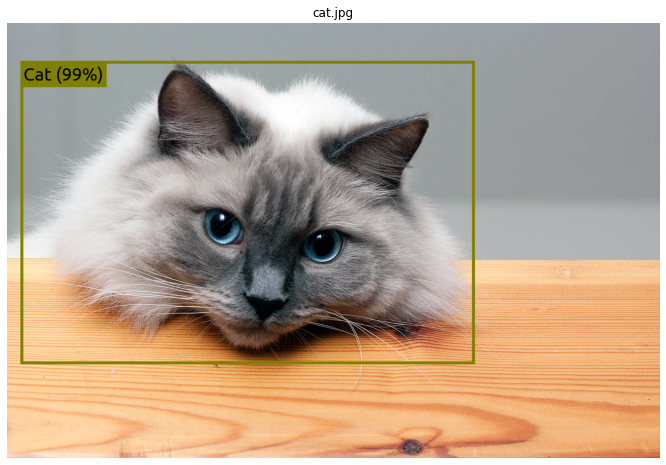

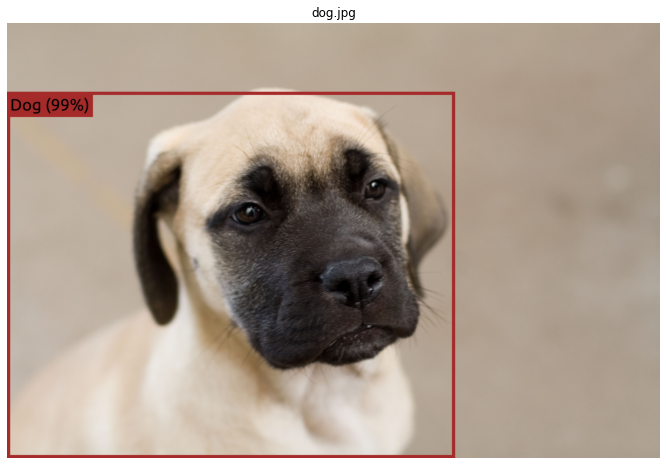

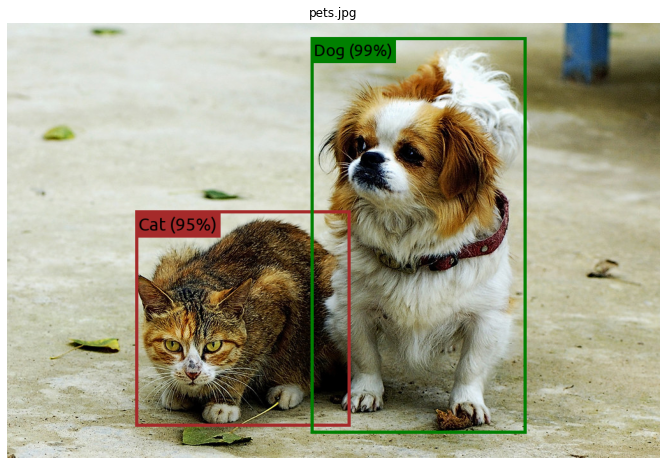

In [23]:
for filename, img_results_dict in file_result_dict.items():
    processed_image = draw_labeled_boxes(img_results_dict[IMAGE_NP_KEY], 
                                         img_results_dict[RESULTS_KEY])
    show_image(filename, processed_image)